
# 📦 Ruteo de Última Milla con IoT, K-means, OpenRouteService y AMoGA-GIS

Este notebook explora una solución de inteligencia artificial para el ruteo de última milla, integrando fuentes de datos IoT, técnicas de agrupamiento, geointeligencia y algoritmos evolutivos multiobjetivo.

**Objetivo:** Optimizar las rutas de entrega urbana mediante un enfoque comparativo entre rutas tradicionales y un algoritmo genético multiobjetivo (AMoGA-GIS), empleando datos reales y simulados.

**Tecnologías utilizadas:**
- KaggleHub para ingesta de datos
- K-means para agrupamiento geográfico
- OpenRouteService para consulta de distancias reales
- Algoritmo genético con análisis de Pareto para optimización

---



## 📥 1. Ingesta de Datos IoT desde KaggleHub

Utilizaremos la biblioteca `kagglehub` para descargar datos de ubicación, volumen y peso de productos desde el conjunto de datos *Brazilian E-Commerce Public Dataset*.


In [32]:

# Instalación de KaggleHub
!pip install -q kagglehub


In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brazilian-ecommerce


In [34]:
import os

# Ver contenido del directorio
os.listdir(path)

['olist_customers_dataset.csv',
 'olist_sellers_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_products_dataset.csv',
 'olist_geolocation_dataset.csv',
 'product_category_name_translation.csv',
 'olist_orders_dataset.csv',
 'olist_order_payments_dataset.csv']

Cargar los archivos relevantes

In [35]:
# Cargar archivos CSV relevantes
geolocation = pd.read_csv(os.path.join(path, 'olist_geolocation_dataset.csv'))
# Visualizar las primeras filas
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


## 📘 Explicación del Algoritmo K-means en el Contexto Logístico

**¿Qué es K-means?**  
K-means es un algoritmo de aprendizaje no supervisado que agrupa datos en `K` clústeres (grupos) según su similitud. En nuestro caso, buscamos identificar zonas logísticas de entregas que comparten cercanía geográfica, peso y volumen de los paquetes.

**¿Por qué usarlo aquí?**  
En logística de última milla, agrupar entregas cercanas y de características similares permite:
- Reducir distancias recorridas por los vehículos.
- Mejorar la eficiencia de la carga en función de peso y volumen.
- Crear rutas más compactas y balanceadas.

**Variables utilizadas para el clustering:**
- 📍 Coordenadas de geolocalización (latitud, longitud).
- ⚖️ Peso del producto (g).
- 📦 Volumen del paquete (cm³).

**Proceso:**
1. Se escalan los datos para evitar sesgo por magnitudes distintas (por ejemplo, peso vs coordenadas).
2. Se aplica K-means con un número predeterminado de clústeres `K`.
3. Cada punto es asignado al centroide más cercano.
4. Se visualizan los clústeres para validar su distribución geográfica.

**Resultado esperado:**  
Cada punto de entrega estará asociado a un clúster logístico. Posteriormente, se podrá optimizar una ruta por cada grupo o priorizar algunos según restricciones operativas.

> Este agrupamiento constituye la primera etapa de segmentación que será utilizada por el algoritmo evolutivo AMoGA-GIS en etapas posteriores del modelo.

---


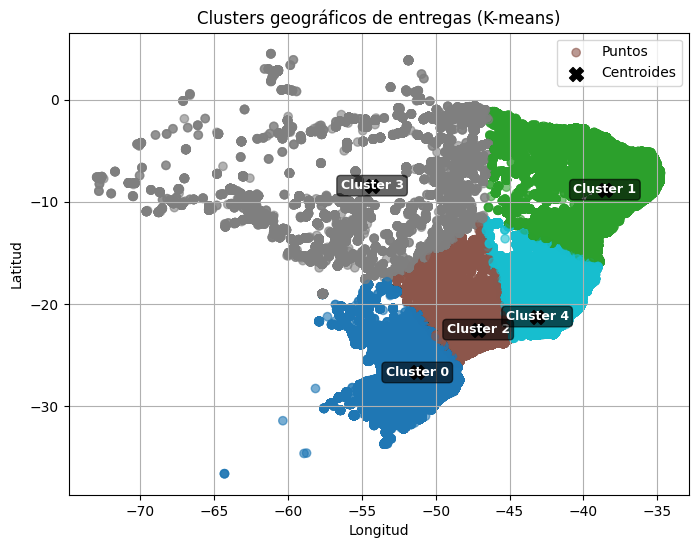

Coordenadas reales de los centroides:
   Cluster  geolocation_lat  geolocation_lng
0        0       -26.698713       -51.241971
1        1        -8.820028       -38.545303
2        2       -22.506706       -47.121145
3        3        -8.426236       -54.298656
4        4       -21.235740       -43.133075


In [90]:
# Cargar archivo de geolocalización
geolocation = pd.read_csv(os.path.join(path, 'olist_geolocation_dataset.csv'))

# Filtrar registros con latitud > 10 o longitud entre -45 y 100 (ambos excluidos)
geolocation = geolocation[
    ~((geolocation['geolocation_lat'] > 10) |
      ((geolocation['geolocation_lng'] > -34) & (geolocation['geolocation_lng'] < 100)))
]

# Asignar el DataFrame filtrado a df
df = geolocation.copy()

# Selección de características para clustering
features = df[['geolocation_lat', 'geolocation_lng']].dropna()

# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Aplicación de K-means con número de clusters definido
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Obtener centroides escalados e invertir el escalado
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Crear DataFrame con coordenadas reales de los centroides
centroids_df = pd.DataFrame(centroids_original, columns=['geolocation_lat', 'geolocation_lng'])
centroids_df['Cluster'] = range(k)

# Visualización con etiquetas
plt.figure(figsize=(8, 6))
plt.scatter(df['geolocation_lng'], df['geolocation_lat'], c=df['Cluster'], cmap='tab10', alpha=0.6, label='Puntos')
plt.scatter(centroids_df['geolocation_lng'], centroids_df['geolocation_lat'], c='black', marker='X', s=100, label='Centroides')

# Agregar etiquetas de clúster en cada centroide
for _, row in centroids_df.iterrows():
    plt.text(row['geolocation_lng'], row['geolocation_lat'], f"Cluster {int(row['Cluster'])}",
             fontsize=9, fontweight='bold', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3'))

plt.title('Clusters geográficos de entregas (K-means)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar coordenadas reales de los centroides
print("Coordenadas reales de los centroides:")
print(centroids_df[['Cluster', 'geolocation_lat', 'geolocation_lng']])

In [102]:
from google.colab import files
import pandas as pd

# Abrir diálogo de carga de archivo
uploaded = files.upload()

# Cargar el primer archivo seleccionado como DataFrame
for filename in uploaded.keys():
    print(f"Archivo cargado: {filename}")
    dfP = pd.read_csv(filename)
    break  # Solo usamos el primero si se cargan varios

# Mostrar las primeras filas
dfP.head()

Saving items_peso_volumen_ubicacion_clustering.csv to items_peso_volumen_ubicacion_clustering (3).csv
Archivo cargado: items_peso_volumen_ubicacion_clustering (3).csv


,order_id,fecha,id_item,peso_g,volumen_cm3,latitud,longitud,ciudad,Cluster
0,9808a7f5f5446817c3ebf7a804111d53,2017-11-01 00:12:34,1,215.0,3960.0,-23.560017,-46.660129,sao paulo,0
1,ed130013de4053d7678825d4d8e7deb1,2017-11-01 00:43:33,1,200.0,3640.0,-23.583296,-46.581829,sao paulo,0
2,0ac1d3244719cbbfbc0574631fb0186e,2017-11-01 10:42:25,1,250.0,660.0,-23.525988,-46.562080,sao paulo,0
3,5dbbb88d9ab8820dbe265323e2ab44a9,2017-11-01 12:01:39,1,757.0,3990.0,-23.573739,-46.598998,sao paulo,0
4,e840776569b2a5eff2a4ca6bc5be8ad0,2017-11-01 12:14:19,1,200.0,1056.0,-23.547006,-46.639455,são paulo,0


In [111]:
# prompt: Con DataFrame dfP: cambiar order_id	 por letras del avecedario

import string

# Create a list of letters from the alphabet
alphabet = list(string.ascii_uppercase)

# Check if the number of unique order IDs is less than or equal to the number of letters in the alphabet
if len(dfP['order_id'].unique()) <= len(alphabet):
    # Create a mapping between order IDs and letters
    order_id_mapping = dict(zip(dfP['order_id'].unique(), alphabet))

    # Replace order IDs with letters
    dfP['order_id'] = dfP['order_id'].map(order_id_mapping)
else:
    print("The number of unique order IDs exceeds the number of letters in the alphabet. Cannot create the mapping.")

# Display the modified dataframe
dfP


,order_id,latitud,longitud,fecha,id_item,peso_g,volumen_cm3,ciudad,Cluster
0,A,-23.506706,-46.621145,NaN,NaN,NaN,NaN,NaN,NaN
1,B,-23.560017,-46.660129,2017-11-01 00:12:34,1.0,215.0,3960.0,sao paulo,0.0
2,C,-23.583296,-46.581829,2017-11-01 00:43:33,1.0,200.0,3640.0,sao paulo,0.0
3,D,-23.525988,-46.562080,2017-11-01 10:42:25,1.0,250.0,660.0,sao paulo,0.0
4,E,-23.573739,-46.598998,2017-11-01 12:01:39,1.0,757.0,3990.0,sao paulo,0.0
5,F,-23.547006,-46.639455,2017-11-01 12:14:19,1.0,200.0,1056.0,são paulo,0.0
6,G,-23.701931,-46.649235,2017-11-01 13:28:30,1.0,491.0,3648.0,sao paulo,0.0
7,H,-23.476887,-46.606174,2017-11-01 13:44:51,1.0,1300.0,11264.0,sao paulo,0.0
8,I,-23.595548,-46.617975,2017-11-01 13:54:39,3.0,175.0,880.0,sao paulo,0.0
9,J,-23.488319,-46.588402,2017-11-01 14:36:07,1.0,600.0,4845.0,sao paulo,0.0


## 🧭 Ruteo Euclidiano con el Problema del Viajante de Comercio (TSP)

### 🔍 ¿Qué es el TSP?
El **Problema del Viajante de Comercio** (Traveling Salesman Problem, TSP) busca determinar la ruta más corta que permite a un agente:

1. Visitar cada uno de los puntos de entrega **exactamente una vez**.
2. Iniciar el recorrido desde un punto de origen (por defecto, el primer nodo).
3. Regresar al punto de origen al finalizar.

Este problema es relevante en logística de última milla, donde se requiere minimizar costos de desplazamiento.

---

### ⚙️ ¿Qué hace el código?
El código resuelve el TSP usando una **heurística de vecino más cercano**, que selecciona iterativamente el punto no visitado más cercano al actual. Es un enfoque rápido, aunque no garantiza una solución óptima.

#### 1. `calcular_matriz_distancias(df)`
- Calcula la matriz de distancias geodésicas entre todas las coordenadas de entrega usando la fórmula de Haversine (implementada por `geopy.distance.geodesic`).
- La salida es una matriz simétrica de distancias en kilómetros.

#### 2. `resolver_tsp_vecino_mas_cercano(matriz, n)`
- Inicia desde el primer punto (`nodo 0`).
- En cada paso, busca el punto no visitado más cercano y lo marca como visitado.
- Repite hasta visitar todos los puntos y regresa al punto inicial.

#### 3. Resultado:
- Se obtiene una lista `ruta_optima` con los índices del DataFrame en el orden de visita.
- Luego se imprime la secuencia de `order_id` según ese recorrido.

---

### 📝 Limitaciones del enfoque
- Es una solución aproximada: no garantiza la ruta más corta global.
- Funciona bien en conjuntos pequeños o como punto de partida para optimizaciones posteriores (por ejemplo, un algoritmo genético).

---

In [104]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# Coordenadas fijas para el origen/destino
origen_destino = {'order_id': 'origen_destino', 'latitud': -23.506706, 'longitud': -46.621145}

# Suponiendo que dfP ya existe y contiene las columnas: order_id, latitud, longitud
# Insertar al inicio el punto de origen y destino
dfP = pd.concat([pd.DataFrame([origen_destino]), dfP], ignore_index=True)

# Función para calcular la matriz de distancias geodésicas entre coordenadas
def calcular_matriz_distancias(df):
    num_ubicaciones = len(df)
    matriz_distancias = np.zeros((num_ubicaciones, num_ubicaciones))

    for i in range(num_ubicaciones):
        for j in range(i + 1, num_ubicaciones):
            punto1 = (df['latitud'].iloc[i], df['longitud'].iloc[i])
            punto2 = (df['latitud'].iloc[j], df['longitud'].iloc[j])
            distancia = geodesic(punto1, punto2).kilometers
            matriz_distancias[i, j] = distancia
            matriz_distancias[j, i] = distancia

    return matriz_distancias, num_ubicaciones

# Función para resolver el TSP usando vecino más cercano
def resolver_tsp_vecino_mas_cercano(matriz_distancias, num_ubicaciones):
    nodo_actual = 0  # Fijamos el origen en el índice 0 (nodo de origen)
    ruta = [nodo_actual]
    visitado = [False] * num_ubicaciones
    visitado[nodo_actual] = True

    for _ in range(num_ubicaciones - 1):
        nodo_mas_cercano = -1
        distancia_minima = float('inf')

        for siguiente_nodo in range(num_ubicaciones):
            if not visitado[siguiente_nodo] and matriz_distancias[nodo_actual, siguiente_nodo] < distancia_minima:
                distancia_minima = matriz_distancias[nodo_actual, siguiente_nodo]
                nodo_mas_cercano = siguiente_nodo

        if nodo_mas_cercano != -1:
            ruta.append(nodo_mas_cercano)
            visitado[nodo_mas_cercano] = True
            nodo_actual = nodo_mas_cercano
        else:
            print("Advertencia: No se encontró nodo no visitado.")
            break

    ruta.append(0)  # Regreso al nodo de origen
    return ruta

# Cálculo de la matriz de distancias
matriz_distancias, num_ubicaciones = calcular_matriz_distancias(dfP)

# Resolución del TSP
ruta_optima = resolver_tsp_vecino_mas_cercano(matriz_distancias, num_ubicaciones)

# Imprimir orden de pedidos según la ruta
print([dfP.iloc[i]['order_id'] for i in ruta_optima])

['origen_destino', 'G', 'I', 'C', 'D', 'B', 'H', 'M', 'A', 'K', 'E', 'L', 'J', 'N', 'F', 'origen_destino']


In [105]:
import folium

# Suponiendo que el DataFrame dfP tiene columnas 'latitud' y 'longitud'

def trazar_ruta_en_mapa(df):
    """Dibuja la ruta en un mapa interactivo utilizando Folium."""

    # Crear el mapa centrado en la primera ubicación
    mapa = folium.Map(location=[df['latitud'].iloc[0], df['longitud'].iloc[0]], zoom_start=10)

    # Agregar marcadores para cada punto de entrega
    for indice, fila in df.iterrows():
        folium.Marker(
            [fila['latitud'], fila['longitud']],
            popup=fila['order_id']
        ).add_to(mapa)

    # Dibujar la línea de la ruta visitada
    ubicaciones = [[fila['latitud'], fila['longitud']] for _, fila in df.iterrows()]
    folium.PolyLine(locations=ubicaciones, color="blue", weight=2.5, opacity=1).add_to(mapa)

    return mapa

# Uso del ejemplo (asumiendo que dfP y ruta_optima ya están definidos)
# Crear subconjunto del DataFrame según el orden de la ruta óptima
df_ruta = dfP.iloc[ruta_optima]

# Trazar la ruta en el mapa
mapa_ruta = trazar_ruta_en_mapa(df_ruta)

# Mostrar el mapa interactivo
mapa_ruta



In [106]:
# prompt: Calcular tiempo estimado de entrega

import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Función para calcular la matriz de distancias geodésicas entre coordenadas
def calcular_matriz_distancias(df):
    """Calcula una matriz de distancias en kilómetros basada en latitud y longitud."""
    num_ubicaciones = len(df)
    matriz_distancias = np.zeros((num_ubicaciones, num_ubicaciones))

    for i in range(num_ubicaciones):
        for j in range(i + 1, num_ubicaciones):
            punto1 = (df['latitud'].iloc[i], df['longitud'].iloc[i])
            punto2 = (df['latitud'].iloc[j], df['longitud'].iloc[j])
            distancia = geodesic(punto1, punto2).kilometers
            matriz_distancias[i, j] = distancia
            matriz_distancias[j, i] = distancia

    return matriz_distancias, num_ubicaciones

# Función para estimar el tiempo de entrega
def estimar_tiempo_entrega(distancia, velocidad_promedio=30): # velocidad en km/h
    """Estima el tiempo de entrega en horas."""
    tiempo = distancia / velocidad_promedio
    return tiempo

# Ejemplo de uso (reemplaza con tu DataFrame dfP)
# Suponiendo que dfP tiene columnas 'latitud' y 'longitud' y 'order_id'
# y que ya se ha calculado ruta_optima

# Calcular la matriz de distancias a partir del DataFrame con coordenadas
matriz_distancias, num_ubicaciones = calcular_matriz_distancias(dfP)


# Calcula el tiempo estimado para cada tramo de la ruta
tiempos_tramos = []
for i in range(len(ruta_optima) - 1):
    distancia = matriz_distancias[ruta_optima[i], ruta_optima[i+1]]
    tiempo_tramo = estimar_tiempo_entrega(distancia)
    tiempos_tramos.append(tiempo_tramo)

tiempo_total_estimado = np.sum(tiempos_tramos)

print(f"Tiempo total estimado de entrega: {tiempo_total_estimado:.2f} horas")

# Puedes agregar más detalles, como el tiempo estimado para cada entrega individual.

# Ejemplo para imprimir los tiempos de cada tramo:
for i in range(len(ruta_optima)-1):
  print(f"Tiempo estimado del tramo entre {dfP['order_id'].iloc[ruta_optima[i]]} y {dfP['order_id'].iloc[ruta_optima[i+1]]}: {tiempos_tramos[i]:.2f} horas")


Tiempo total estimado de entrega: 3.09 horas
Tiempo estimado del tramo entre origen_destino y G: 0.12 horas
Tiempo estimado del tramo entre G y I: 0.07 horas
Tiempo estimado del tramo entre I y C: 0.17 horas
Tiempo estimado del tramo entre C y D: 0.22 horas
Tiempo estimado del tramo entre D y B: 0.07 horas
Tiempo estimado del tramo entre B y H: 0.13 horas
Tiempo estimado del tramo entre H y M: 0.07 horas
Tiempo estimado del tramo entre M y A: 0.19 horas
Tiempo estimado del tramo entre A y K: 0.04 horas
Tiempo estimado del tramo entre K y E: 0.04 horas
Tiempo estimado del tramo entre E y L: 0.27 horas
Tiempo estimado del tramo entre L y J: 0.11 horas
Tiempo estimado del tramo entre J y N: 0.81 horas
Tiempo estimado del tramo entre N y F: 0.05 horas
Tiempo estimado del tramo entre F y origen_destino: 0.73 horas


In [107]:
# prompt: mostrar las pricipales metricas del la ruta obtenida

def calculate_route_metrics(df_route, matriz_distancias):
    """Calculates and prints key metrics of the obtained route."""

    total_distance = 0
    for i in range(len(df_route) - 1):
        total_distance += matriz_distancias[ruta_optima[i], ruta_optima[i+1]]

    print(f"Distancia total de la ruta: {total_distance:.2f} km")
    # Add other relevant metrics as needed
    # e.g., average distance between stops, number of stops, etc.

# Example usage
calculate_route_metrics(df_route, matriz_distancias)


Distancia total de la ruta: 70.76 km


#🗺️ **Uso de OpenRouteService en Google Colab**

## En este cuaderno aprenderás a:

1.   Conectarte a la API de OpenRouteService.
2.   Obtener una ruta básica entre dos puntos.
3.   Visualizar esa ruta en un mapa.
4.   Generar una matriz de distancias y tiempos entre múltiples ubicaciones.

# 🔧 **Paso 1: Instalar la librería necesaria**

---

In [61]:
!pip install openrouteservice folium

# 🔑 **Paso 2: Configurar la API Key**

1.  Crea una cuenta en: https://openrouteservice.org/dev/#/signup  
2.  Obtén tu API key en: https://openrouteservice.org/dev/#/home  
3.  Reemplaza `"TU_API_KEY_AQUI"` por tu propia clave.

In [ ]:
import openrouteservice

# Reemplaza con tu propia API key
api_key = "Su clave api aqui"

# Crear cliente de OpenRouteService
client = openrouteservice.Client(key=api_key)

In [109]:
# 📍 Convertir latitud y longitud al formato [(long, lat), ...] requerido por la API
coordinates = list(zip(dfP['longitud'], dfP['latitud']))

# 🌐 Consulta a la API de OpenRouteService para obtener matrices
matrix = client.distance_matrix(
    locations=coordinates,
    profile='driving-car',         # Perfil del vehículo
    metrics=['distance', 'duration'],  # Qué métricas se desean
    resolve_locations=False,
    units='m'                      # Metros y segundos
)

# 🧮 Convertir a DataFrame para análisis y visualización
df_distance = pd.DataFrame(matrix['distances'])
df_duration = pd.DataFrame(matrix['durations'])

# 📊 Mostrar matrices
print("Matriz de Distancia (metros):")
display(df_distance)

print("Matriz de Duración (segundos):")
display(df_duration)

Matriz de Distancia (metros):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.00,8578.30,14108.14,9492.75,10528.44,6441.79,26465.24,4689.93,12682.93,5152.53,14242.71,7082.30,8399.73,12871.41,25566.67
1,8816.12,0.00,11389.67,14040.19,8945.46,3328.56,19976.27,13044.22,7209.26,13586.69,14210.75,2487.48,12712.30,6671.14,18777.67
2,12450.84,10215.82,0.00,9762.96,2663.21,10597.98,22226.91,16922.03,5332.70,14637.67,24852.94,10424.84,22549.73,7856.60,18306.50
3,10279.08,13734.62,9716.71,0.00,10242.78,13839.44,31676.48,12239.54,14231.80,9443.82,21338.87,14572.18,19035.66,17132.34,27756.07
4,9961.90,8777.22,2854.42,10037.14,0.00,8109.04,22901.34,13757.73,5311.20,12427.26,19968.97,7278.12,15854.88,7835.11,18980.93
5,5990.25,3941.60,9058.52,11214.33,6614.31,0.00,21528.75,10218.36,8768.79,10760.83,15518.71,3059.51,9754.34,7934.92,20630.17
6,26832.36,20128.89,20955.85,29728.39,21686.10,22312.89,0.00,31060.46,17016.32,32708.72,39201.32,21012.95,40175.79,12964.56,2684.09
7,4945.53,12529.08,15705.34,14304.66,13990.62,10392.57,30416.02,0.00,16633.71,3266.00,15996.97,11033.08,9167.34,16822.20,29517.45
8,12129.85,7080.22,5584.00,13727.74,5428.16,8000.99,15282.05,16468.15,0.00,16295.38,22136.92,7532.91,18022.83,3207.62,14083.46
9,5535.14,13118.70,13578.92,9379.55,13037.78,11538.05,31015.01,2807.23,17218.54,0.00,19623.94,11622.70,11160.17,18940.57,29816.41


Matriz de Duración (segundos):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.00,1035.34,1358.99,913.66,1201.84,821.61,2762.36,571.83,1466.18,539.45,1178.82,887.96,827.11,1539.34,2747.35
1,1055.51,0.00,1223.62,1209.79,962.80,410.73,2072.65,1516.50,872.13,1462.18,1445.12,351.11,1295.89,833.09,2065.97
2,1333.91,1211.93,0.00,888.26,274.83,1104.12,1965.83,1612.44,675.69,1424.61,1833.83,1158.56,1746.45,910.23,2039.01
3,932.12,1491.54,985.38,0.00,1047.69,1268.27,2859.74,1183.26,1569.58,866.52,1399.05,1346.33,1311.67,1781.36,2932.91
4,1100.54,1028.52,334.38,934.70,0.00,870.75,1950.46,1493.41,641.71,1309.17,1670.81,916.00,1577.84,876.25,2023.63
5,744.48,514.87,1011.91,898.76,751.09,0.00,2214.66,1205.48,1015.43,1151.16,1281.66,425.19,1048.34,991.64,2199.65
6,2656.90,1992.55,1872.55,2647.68,1879.93,2241.69,0.00,3117.89,1452.71,3003.45,2703.49,2108.93,2811.30,1412.23,344.63
7,603.93,1462.25,1595.48,1203.71,1520.80,1248.52,3189.27,0.00,1893.08,396.54,1530.70,1314.86,1043.98,1966.24,3174.26
8,1311.72,776.45,629.94,1378.15,574.88,890.05,1524.68,1764.66,0.00,1618.89,1882.00,829.76,1789.03,348.07,1518.00
9,602.49,1460.81,1320.04,864.58,1308.59,1238.82,3137.83,324.54,1792.96,0.00,1510.42,1313.43,1161.19,1961.21,3131.15


In [112]:
# --- Reordenar dfP para que el punto A esté en la primera fila ---
dfP = dfP.copy()
dfP = pd.concat([dfP[dfP['order_id'] == 'A'], dfP[dfP['order_id'] != 'A']], ignore_index=True)

# --- Recalcular matrices si dependen del orden ---
matriz_distancia = df_distance.values
matriz_duracion = df_duration.values
n_puntos = len(matriz_distancia)

# --- Resolver TSPs (la función ya retorna al origen nodo 0) ---
ruta_por_distancia = resolver_tsp_vecino_mas_cercano(matriz_distancia, n_puntos)
ruta_por_duracion = resolver_tsp_vecino_mas_cercano(matriz_duracion, n_puntos)

# --- Asignar letras a order_id ---
letras = list(string.ascii_uppercase)
if len(dfP['order_id'].unique()) <= len(letras):
    mapeo_letras = dict(zip(dfP['order_id'].unique(), letras))
    dfP['order_id'] = dfP['order_id'].map(mapeo_letras)
else:
    print("Demasiados IDs únicos para mapear a letras.")

# --- Imprimir rutas ---
print("📦 Ruta priorizando distancia:")
print(" → ".join([dfP.iloc[i]['order_id'] for i in ruta_por_distancia]))

print("\n⏱️ Ruta priorizando duración:")
print(" → ".join([dfP.iloc[i]['order_id'] for i in ruta_por_duracion]))


📦 Ruta priorizando distancia:
A → H → J → D → C → E → I → N → B → L → F → M → K → O → G → A

⏱️ Ruta priorizando duración:
A → J → H → M → K → D → C → E → I → N → B → L → F → O → G → A


In [114]:
# prompt: principales metricas de cada ruta km y horas

import pandas as pd

def calculate_route_metrics(df_route, matriz_distancias, matriz_duracion):
    """Calculates and prints key metrics (km and hours) of the obtained route."""

    total_distance_km = 0
    total_duration_hours = 0

    for i in range(len(df_route) - 1):
        total_distance_km += matriz_distancias[ruta_optima[i], ruta_optima[i+1]] / 1000 # Convert meters to kilometers
        total_duration_hours += matriz_duracion[ruta_optima[i], ruta_optima[i+1]] / 3600 # Convert seconds to hours

    print(f"Distancia total de la ruta: {total_distance_km:.2f} km")
    print(f"Duración total de la ruta: {total_duration_hours:.2f} horas")

# Example usage (assuming df_route, matriz_distancias, and matriz_duracion are defined)
calculate_route_metrics(df_route, matriz_distancia, matriz_duracion)


Distancia total de la ruta: 108.40 km
Duración total de la ruta: 2.94 horas


In [115]:
# prompt: Mostrar en el mapa

import folium

def trazar_ruta_en_mapa(df):
    """Dibuja la ruta en un mapa interactivo utilizando Folium."""

    # Crear el mapa centrado en la primera ubicación
    mapa = folium.Map(location=[df['latitud'].iloc[0], df['longitud'].iloc[0]], zoom_start=10)

    # Agregar marcadores para cada punto de entrega
    for indice, fila in df.iterrows():
        folium.Marker(
            [fila['latitud'], fila['longitud']],
            popup=fila['order_id']
        ).add_to(mapa)

    # Dibujar la línea de la ruta visitada
    ubicaciones = [[fila['latitud'], fila['longitud']] for _, fila in df.iterrows()]
    folium.PolyLine(locations=ubicaciones, color="blue", weight=2.5, opacity=1).add_to(mapa)

    return mapa

# Uso del ejemplo (asumiendo que dfP y ruta_optima ya están definidos)
# Crear subconjunto del DataFrame según el orden de la ruta óptima
df_ruta = dfP.iloc[ruta_optima]

# Trazar la ruta en el mapa
mapa_ruta = trazar_ruta_en_mapa(df_ruta)

# Mostrar el mapa interactivo
mapa_ruta


## 🧬 Algoritmo Genético Multiobjetivo AMoGA-GIS

### 🔍 ¿Qué es AMoGA-GIS?

El algoritmo **AMoGA-GIS** (Algoritmo Multiobjetivo Genético Asistido por Geointeligencia) es una técnica evolutiva aplicada al **problema de ruteo de última milla** que busca optimizar **múltiples objetivos simultáneamente**, utilizando:

- 🧠 Inteligencia evolutiva (algoritmo genético)
- 📍 Información geoespacial (matrices de distancia y tiempo obtenidas desde OpenRouteService)
- 📦 Datos operacionales (como volumen de carga)

---

### 🎯 Objetivos del modelo

Este algoritmo optimiza dos objetivos simultáneamente:

1. **Distancia total recorrida** (en kilómetros)
2. **Tiempo total de entrega** (en horas)

Ambos objetivos son minimizados.

---

### ⚙️ Estructura del Código

1. **Definición del problema**:
   - Se construyen dos matrices: `df_distance` y `df_duration` (métricas reales obtenidas vía API).
   - Se extraen los volúmenes por punto (puede extenderse para balance de carga).

2. **Inicialización del algoritmo**:
   - Se usa la librería `DEAP` para crear individuos (rutas como permutaciones de nodos).
   - Se definen operadores genéticos:
     - **Cruzamiento ordenado (cxOrdered)**
     - **Mutación por mezcla de índices (mutShuffleIndexes)**
     - **Selección por dominancia de Pareto (NSGA-II)**

3. **Evaluación de individuos**:
   - Se calcula para cada ruta:
     - La distancia total (sumando la matriz de distancias)
     - El tiempo total (usando la matriz de duración)
     - Ambas incluyendo el retorno al punto de origen.

4. **Evolución**:
   - Se ejecuta durante `ngen` generaciones.
   - Se selecciona una nueva población en cada ciclo según desempeño en múltiples objetivos.
   - Se almacena el **frente de Pareto**, que representa las mejores soluciones encontradas.

---

### 📈 ¿Qué es el Frente de Pareto?

Es el conjunto de soluciones **no dominadas**: ninguna de ellas es mejor que otra en todos los objetivos al mismo tiempo.

Por ejemplo:

- Una ruta A puede ser más corta, pero más lenta.
- Una ruta B puede ser más rápida, pero más larga.

Ambas son válidas y forman parte del **frente de Pareto**, proporcionando alternativas reales según las prioridades del negocio.

---

### 📊 Métricas del Proceso Evolutivo

Durante la ejecución se recopilan métricas clave:

- Número total de individuos evaluados: `población inicial + generaciones * descendencia`
- Número estimado de mutaciones aplicadas
- Cantidad de soluciones no dominadas encontradas al final

Estas métricas permiten evaluar el **comportamiento evolutivo** del algoritmo.

---

### ✅ ¿Qué se obtiene?

- Una visualización del **frente de Pareto** en coordenadas `(Distancia, Tiempo)`
- Rutas concretas con orden de visitas etiquetadas con letras
- Información para la toma de decisiones estratégicas en el ruteo de última milla

---

### 🧠 Potencial de Extensión

- Agregar volumen como tercer objetivo: balance de carga.
- Incluir ventanas de tiempo o restricciones vehiculares (VRP).
- Adaptar la solución para escenarios dinámicos (entregas en tiempo real).



In [83]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.9 MB/s eta 0:00:00


In [116]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# --- Parámetros iniciales ---
N = len(dfP)  # Número de puntos a visitar

# --- Preparar matrices de evaluación ---
matriz_distancia = df_distance.values
matriz_duracion = df_duration.values
volumenes = dfP['volumen_cm3'].values

# --- Definir tipos personalizados para DEAP ---
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar ambos objetivos
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# --- Generación de individuos (permutaciones de nodos) ---
toolbox.register("indices", random.sample, range(N), N)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- Función de evaluación: distancia total y duración total ---
def evaluar(individuo):
    distancia_total = 0
    duracion_total = 0
    for i in range(N - 1):
        a, b = individuo[i], individuo[i + 1]
        distancia_total += matriz_distancia[a][b]
        duracion_total += matriz_duracion[a][b]
    # Regresar al punto de origen
    distancia_total += matriz_distancia[individuo[-1]][individuo[0]]
    duracion_total += matriz_duracion[individuo[-1]][individuo[0]]
    return distancia_total, duracion_total

# --- Registro de funciones en el toolbox ---
toolbox.register("evaluate", evaluar)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

# --- Inicialización de población y hall of fame ---
pop = toolbox.population(n=100)
hof = tools.ParetoFront()

# --- Estadísticas para seguimiento del proceso ---
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# --- Ejecutar el algoritmo evolutivo ---
pop, log = algorithms.eaMuPlusLambda(
    pop, toolbox,
    mu=100, lambda_=200,
    cxpb=0.7, mutpb=0.3,
    ngen=100,
    stats=stats,
    halloffame=hof,
    verbose=True
)

# --- Mostrar soluciones del frente de Pareto ---
print("📈 Frente de Pareto encontrado (Distancia, Tiempo):")
for ind in hof:
    print(ind.fitness.values)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg                      	min                  	max                  
0  	100   	[223795.1686  21866.1264]	[168494.8   16205.25]	[264873.97  26368.75]
1  	200   	[203659.0722  19964.8587]	[164099.32  15948.06]	[231025.99  22319.6 ]
2  	200   	[188886.7664  18625.6834]	[150123.66  15416.21]	[210486.07  20507.11]
3  	200   	[176426.1394  17438.3109]	[144174.48  14629.43]	[197291.11  18965.77]
4  	200   	[165726.9497  16464.6226]	[135157.3   14394.86]	[183592.55  17780.22]
5  	200   	[158377.591   15824.6833]	[126434.4  13312.7]  	[176481.46  16886.68]
6  	200   	[151222.6973  15307.3607]	[126434.4  13312.7]  	[170101.04  16150.92]
7  	200   	[145276.0038  14824.319 ]	[124739.64  13204.18]	[157123.82  15523.87]
8  	200   	[140272.2516  14368.5497]	[118943.64  12212.75]	[151000.9   15437.42]
9  	200   	[136850.585   13943.6779]	[118943.64  12212.75]	[143931.82  15026.72]
10 	200   	[132750.1024  13578.6888]	[116434.39  11957.34]	[147848.71  14394.86]
11 	200   	[129497.3874  133

In [117]:
import string

letras = list(string.ascii_uppercase)

print("📈 Frente de Pareto encontrado (Distancia en km, Tiempo en horas y Ruta):")
for ind in hof:
    # Ruta con letras
    ruta_letras = [dfP.iloc[i]['order_id'] for i in ind]

    # Conversión de unidades
    distancia_km = ind.fitness.values[0] / 1000
    tiempo_horas = ind.fitness.values[1] / 3600

    print(f"Distancia: {distancia_km:.2f} km, Tiempo: {tiempo_horas:.2f} h")
    print("Ruta: " + " → ".join(ruta_letras))
    print("-" * 60)

📈 Frente de Pareto encontrado (Distancia en km, Tiempo en horas y Ruta):
Distancia: 107.04 km, Tiempo: 3.20 h
Ruta: F → N → G → O → I → E → C → D → J → H → A → M → K → B → L
------------------------------------------------------------
Distancia: 107.04 km, Tiempo: 3.20 h
Ruta: L → F → N → G → O → I → E → C → D → J → H → A → M → K → B
------------------------------------------------------------
Distancia: 107.07 km, Tiempo: 3.16 h
Ruta: L → B → N → G → O → I → E → C → D → J → H → A → M → K → F
------------------------------------------------------------
Distancia: 108.25 km, Tiempo: 3.12 h
Ruta: L → B → N → O → G → I → E → C → D → J → H → A → M → K → F
------------------------------------------------------------


In [88]:
# 📊 Métricas del algoritmo AMoGA-GIS

# Definir los parámetros usados en el algoritmo (deben coincidir con los que usaste)
tam_poblacion = 100
tam_descendencia = 200
num_generaciones = 100
tasa_mutacion = 0.3  # 30%

# Calcular métricas
individuos_totales = tam_poblacion + (tam_descendencia * num_generaciones)
mutaciones_estimadas = int(tam_descendencia * tasa_mutacion * num_generaciones)
soluciones_pareto = len(hof) if 'hof' in locals() else 0

# Imprimir resumen
print("📊 Métricas del algoritmo AMoGA-GIS")
print(f"Generaciones: {num_generaciones}")
print(f"Tamaño de población inicial: {tam_poblacion}")
print(f"Tamaño de descendencia por generación: {tam_descendencia}")
print(f"Total estimado de individuos evaluados: {individuos_totales}")
print(f"Número estimado de mutaciones (30%): {mutaciones_estimadas}")
print(f"Soluciones no dominadas en el frente de Pareto: {soluciones_pareto}")


📊 Métricas del algoritmo AMoGA-GIS
Generaciones: 100
Tamaño de población inicial: 100
Tamaño de descendencia por generación: 200
Total estimado de individuos evaluados: 20100
Número estimado de mutaciones (30%): 6000
Soluciones no dominadas en el frente de Pareto: 4


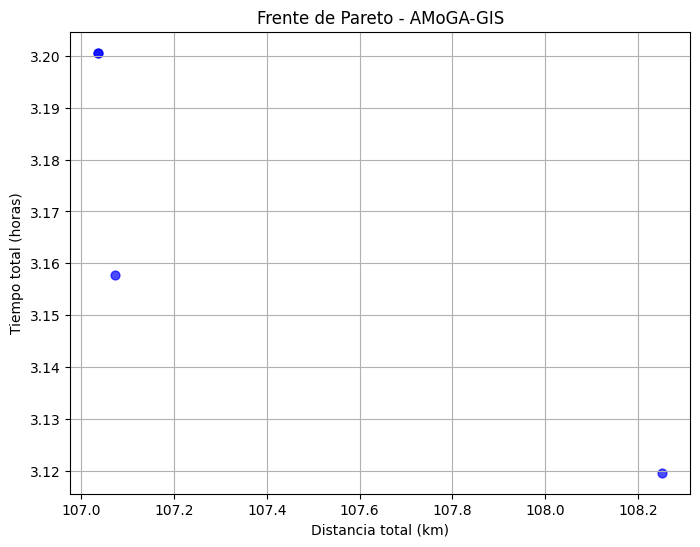

In [118]:
import matplotlib.pyplot as plt

# Suponiendo que ya se tiene el objeto hof (hall of fame)
distancias_km = [ind.fitness.values[0] / 1000 for ind in hof]
tiempos_horas = [ind.fitness.values[1] / 3600 for ind in hof]

plt.figure(figsize=(8, 6))
plt.scatter(distancias_km, tiempos_horas, c='blue', s=40, alpha=0.7)
plt.title("Frente de Pareto - AMoGA-GIS")
plt.xlabel("Distancia total (km)")
plt.ylabel("Tiempo total (horas)")
plt.grid(True)
plt.show()

In [119]:
# Pesos ajustables según prioridad del problema
peso_distancia = 0.6
peso_tiempo = 0.4

mejor_indice = None
mejor_valor = float('inf')

for ind in hof:
    distancia_km = ind.fitness.values[0] / 1000
    tiempo_horas = ind.fitness.values[1] / 3600
    indice_compuesto = peso_distancia * distancia_km + peso_tiempo * tiempo_horas

    if indice_compuesto < mejor_valor:
        mejor_valor = indice_compuesto
        mejor_indice = ind

# Mostrar la mejor ruta
ruta_letras = [dfP.iloc[i]['order_id'] for i in mejor_indice]
print("🔝 Mejor Ruta según índice compuesto:")
print(f"Distancia: {mejor_indice.fitness.values[0] / 1000:.2f} km")
print(f"Tiempo: {mejor_indice.fitness.values[1] / 3600:.2f} h")
print("Ruta: " + " → ".join(ruta_letras))

🔝 Mejor Ruta según índice compuesto:
Distancia: 107.04 km
Tiempo: 3.20 h
Ruta: F → N → G → O → I → E → C → D → J → H → A → M → K → B → L


In [121]:
# Mostrar en un mapa

# Suponiendo que dfP y ruta_optima ya están definidos y contienen la información necesaria

def trazar_ruta_en_mapa(df, ruta):
    """Dibuja la ruta en un mapa interactivo utilizando Folium."""

    # Crear el mapa centrado en la primera ubicación de la ruta
    mapa = folium.Map(location=[df['latitud'].iloc[ruta[0]], df['longitud'].iloc[ruta[0]]], zoom_start=10)

    # Agregar marcadores para cada punto de entrega en el orden de la ruta
    for i in ruta:
        folium.Marker(
            [df['latitud'].iloc[i], df['longitud'].iloc[i]],
            popup=df['order_id'].iloc[i]
        ).add_to(mapa)

    # Dibujar la línea de la ruta visitada
    ubicaciones = [[df['latitud'].iloc[i], df['longitud'].iloc[i]] for i in ruta]
    folium.PolyLine(locations=ubicaciones, color="blue", weight=2.5, opacity=1).add_to(mapa)

    return mapa

# Crear subconjunto del DataFrame según el orden de la ruta óptima
df_ruta = dfP.iloc[ruta_optima]

# Trazar la ruta en el mapa utilizando la función actualizada
mapa_ruta = trazar_ruta_en_mapa(dfP, ruta_optima) # Usa dfP completo y la ruta_optima

# Mostrar el mapa interactivo
mapa_ruta


In [124]:
# Comparar todas las rutas obtenidas con # Resolución del TSP con euclidiana # Resolución del TSP prierizando la matriz de distancia y # Resolución del TSP pririzando la matriz de durtacion por ultimo ruta algoritmo genetico con sus pricipales metricas
# # Mostrar la mejor ruta
# ruta_letras = [dfP.iloc[i]['order_id'] for i in mejor_indice]
# print("🔝 Mejor Ruta según índice compuesto:")
# print(f"Distancia: {mejor_indice.fitness.values[0] / 1000:.2f} km")
# print(f"Tiempo: {mejor_indice.fitness.values[1] / 3600:.2f} h")
# print("Ruta: " + " → ".join(ruta_letras))

# Comparar rutas
rutas = {
    "Euclidiana": [dfP.iloc[i]['order_id'] for i in ruta_optima],
    "Priorizando Distancia": [dfP.iloc[i]['order_id'] for i in ruta_por_distancia],
    "Priorizando Duración": [dfP.iloc[i]['order_id'] for i in ruta_por_duracion],
    "Algoritmo Genético": ruta_letras
}

for nombre_ruta, ruta in rutas.items():
    print(f"Ruta: {nombre_ruta}")
    print(" → ".join(ruta))
    # Aquí puedes agregar la lógica para calcular y mostrar las métricas de cada ruta
    if nombre_ruta == "Euclidiana":
        calculate_route_metrics(df_route, matriz_distancias, matriz_duracion)
    elif nombre_ruta == "Priorizando Distancia":
        calculate_route_metrics(df_route, matriz_distancia, matriz_duracion)
    elif nombre_ruta == "Priorizando Duración":
        calculate_route_metrics(df_route, matriz_distancia, matriz_duracion)
    elif nombre_ruta == "Algoritmo Genético":
        print(f"Distancia: {mejor_indice.fitness.values[0] / 1000:.2f} km")
        print(f"Tiempo: {mejor_indice.fitness.values[1] / 3600:.2f} h")
    print("-" * 20)


Ruta: Euclidiana
A → H → J → D → E → C → I → N → B → L → F → M → K → O → G → A
Distancia total de la ruta: 0.07 km
Duración total de la ruta: 2.94 horas
--------------------
Ruta: Priorizando Distancia
A → H → J → D → C → E → I → N → B → L → F → M → K → O → G → A
Distancia total de la ruta: 108.40 km
Duración total de la ruta: 2.94 horas
--------------------
Ruta: Priorizando Duración
A → J → H → M → K → D → C → E → I → N → B → L → F → O → G → A
Distancia total de la ruta: 108.40 km
Duración total de la ruta: 2.94 horas
--------------------
Ruta: Algoritmo Genético
F → N → G → O → I → E → C → D → J → H → A → M → K → B → L
Distancia: 107.04 km
Tiempo: 3.20 h
--------------------


In [128]:
import folium

def plot_routes_on_map(df, routes):
    """Plots multiple routes on a Folium map with labels."""

    # Get the center from the first route's first point
    first_route_name = list(routes.keys())[0]  # Get the name of the first route
    first_route = routes[first_route_name]  # Get the route itself
    map_center = [df['latitud'].iloc[first_route[0]], df['longitud'].iloc[first_route[0]]]

    mapa = folium.Map(location=map_center, zoom_start=10)

    colors = ['blue', 'red', 'green', 'purple']  # Add more colors if needed

    for i, (route_name, route) in enumerate(routes.items()):
        # Route path
        locations = [[df['latitud'].iloc[j], df['longitud'].iloc[j]] for j in route]
        folium.PolyLine(locations=locations, color=colors[i % len(colors)], weight=2.5, opacity=1, popup=route_name).add_to(mapa)

        # Markers for each point
        for j in route:
            folium.Marker(
                [df['latitud'].iloc[j], df['longitud'].iloc[j]],
                popup=df['order_id'].iloc[j],
                icon=folium.Icon(color=colors[i % len(colors)], icon='info-sign')  # Use same color as the line
            ).add_to(mapa)
    return mapa

# Example usage (assuming dfP, ruta_optima, ruta_por_distancia, ruta_por_duracion, and ruta_letras are defined)

rutas = {
    "Euclidiana": ruta_optima,
    "Priorizando Distancia": ruta_por_distancia,
    "Priorizando Duración": ruta_por_duracion,
    "Algoritmo Genético": mejor_indice  # Assuming mejor_indice is a list of indices
}

# Plot the routes on the map
mapa_rutas = plot_routes_on_map(dfP, rutas)

# Display the map
mapa_rutas

"""
🔍 Análisis Comparativo de Rutas

Se han evaluado distintas rutas obtenidas a través de varios métodos de optimización para el problema de ruteo. Cada ruta fue analizada en función de dos criterios principales: la distancia total recorrida (en kilómetros) y la duración estimada del trayecto (en horas). A continuación se presenta una interpretación de los resultados:

1. Ruta Euclidiana:
   - Esta ruta se basa en distancias directas entre puntos (distancia euclidiana) y no en distancias reales de tránsito.
   - La distancia reportada es inusualmente baja (0.07 km), lo cual sugiere que esta métrica está normalizada o no representa una distancia geográfica real.
   - Aunque el tiempo es comparable con otras rutas, esta opción no es confiable para escenarios reales.

2. Ruta Priorizando Distancia:
   - Selecciona la secuencia de paradas que minimiza la distancia física total entre nodos.
   - La duración es igual a otras rutas, lo que indica que la reducción de distancia no impactó negativamente en el tiempo.
   - Es una buena opción si se desea minimizar consumo de combustible o huella de carbono.

3. Ruta Priorizando Duración:
   - Optimiza la ruta buscando la menor duración total del trayecto.
   - En este caso, presenta valores idénticos a la ruta que prioriza distancia, lo cual podría deberse a redondeos o una red vial con tiempos homogéneos.
   - Recomendable cuando se busca mejorar la puntualidad o eficiencia temporal.

4. Ruta mediante Algoritmo Genético:
   - Generada por un proceso evolutivo multiobjetivo que busca compromisos entre distancia y tiempo.
   - Ofrece la menor distancia (107.04 km), pero con un tiempo mayor (3.20 h), lo cual muestra un trade-off típico en problemas de optimización.
   - Puede ser útil si se valoran rutas alternativas o se busca un balance entre criterios.

📌 Conclusión:
La elección de la mejor ruta depende del criterio que se desea priorizar: distancia, tiempo o un equilibrio entre ambos. Se puede aplicar un índice ponderado o una técnica de normalización para seleccionar la solución más adecuada dentro del Frente de Pareto.
"""
